In [1]:
import json
import os
import re
import nltk
import time
import pickle
from nltk import pos_tag
from six import string_types

from nltk.tokenize import TweetTokenizer

from nltk.corpus.reader.util import StreamBackedCorpusView, concat, ZipFilePathPointer
from nltk.corpus.reader.api import CorpusReader

DOC_PATTERN = r'.*\.json' 
# PKL_PATTERN = r'.*\.pickle'

##########################################################################
## Tweets Corpus Reader
##########################################################################

class TweetsCorpusReader(CorpusReader):

    """
    Reader for corpora that consist of Tweets represented as a list of line-delimited JSON.
    Individual Tweets can be tokenized using the default tokenizer, or by a
    custom tokenizer specified as a parameter to the constructor.
    Construct a new Tweet corpus reader for a set of documents
    located at the given root directory.
    If you want to work directly with the raw Tweets, the `json` library can
    be used::
       import json
       for tweet in reader.docs():
           print(json.dumps(tweet, indent=1, sort_keys=True))
    """

    CorpusView = StreamBackedCorpusView  # The corpus view class used by this reader.

    def __init__(self, root, fileids=None, word_tokenizer=TweetTokenizer(), encoding='utf-8-sig', bullying_trace='bullying_trace'):

        CorpusReader.__init__(self, root, fileids, encoding, bullying_trace)

        for path in self.abspaths(self._fileids):
            if isinstance(path, ZipFilePathPointer):
                pass
            elif os.path.getsize(path) == 0:
                raise ValueError("File {} is empty".format(path))
        """Check that all user-created corpus files are non-empty."""

        self._word_tokenizer = word_tokenizer
        self._bullying_trace = bullying_trace
    
    def _read_tweets(self, stream):
        """
        Assumes that each line in ``stream`` is a JSON-serialised object.
        """
        tweets = []
        for i in range(100):
            line = stream.readline()
            if not line:
                return tweets
            tweet = json.loads(line)
            tweets.append(tweet)
        return tweets

    def docs(self, fileids=None, bullying_trace=None):
        """
        Returns the full Tweet objects, 
        :return: the given file(s) as a list of dictionaries deserialised from JSON.
        :rtype: list(dict)
        """
        tweets = concat(
            [
                self.CorpusView(path, self._read_tweets, encoding=enc)
                for (path, enc, fileid) in self.abspaths(fileids, True, True)
            ])
        
        # tweets = [tweet for tweet in tweets]
        remove = [None,'remove', float('nan'), 'nan', 'None'] #'nan
        tweets = [tweet for tweet in tweets if str(tweet[self._bullying_trace]) not in remove]

        return tweets 
            
    def sizes(self, fileids=None):
        """
        Returns a list of tuples, the fileid and size on disk of the file.
        This function is used to detect oddly large files in the corpus.
        """
        # Create a generator, getting every path and computing filesize
        for path in self.abspaths(fileids):
            yield os.path.getsize(path)

    def fields(self, fields, fileids=None):
        """
        extract particular fields from the json doc. Can be string or an 
        iterable of fields. If just one fields in passed in, then the values 
        are returned, otherwise dictionaries of the requested fields returned
        """
        if isinstance(fields, string_types):
            fields = [fields,]

        if len(fields) == 1:
            for doc in self.docs(fileids):
                if fields[0] in doc:
                    yield doc[fields[0]]

        else:
            for doc in self.docs(fileids):
                yield {
                    key : doc.get(key, None)
                    for key in fields
                }
    
    def strings(self, fileids=None):
        """
        Returns only the text content of Tweets in the file(s)
        :return: the given file(s) as a list of Tweets.
        :rtype: list(str)
        """
        fulltweets = self.docs(fileids)
        tweets = []
        for jsono in fulltweets:
            try:
                text = jsono['full_tweet']
                if isinstance(text, bytes):
                    text = text.encode('latin-1').decode('utf-8') #.decode(self.encoding) #
                tweets.append(text)
            except KeyError:
                pass
        return tweets

    def tokenized(self, fileids=None):
        """
        :return: the given file(s) as a list of the text content of Tweets as
        as a list of words, screenanames, hashtags, URLs and punctuation symbols.
        :rtype: list(list(str))
        """
        tweets = self.strings(fileids)
        tokenizer = self._word_tokenizer
        tokenized = [tokenizer.tokenize(t) for t in tweets]
        return [ pos_tag(token) for token in tokenized ]
    
    def process_tweet(self, fileids=None):

		# emoji_pattern = re.compile("["
        # u"\U0001F600-\U0001F64F"  # emoticons
        # u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        # u"\U0001F680-\U0001F6FF"  # transport & map symbols
        # u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        # u"\U00002702-\U000027B0"
        # u"\U000024C2-\U0001F251"
        # "]+", flags=re.UNICODE)
        tagged_tweets = self.tokenized(fileids)
        mod_tweets = []
        for tweet in tagged_tweets:
            mod_tweet=[]
            for (token, tag) in tweet: 
                if '@' in token:
                    token = '@user'
                elif '#' in token:
                    token = token[1:]
                elif ('http' or 'https') in token:
                    token = 'URL'
                elif token == 'luv':
                    token = 'love'
                else:
                    pass
                mod_tweet.append((re.sub(r'[^\w\d\s\']+', '', token),tag))
            mod_tweets.append(mod_tweet)
        return mod_tweets

    def raw(self, fileids=None):
        """
        Return the corpora in their raw form.
        """
        if fileids is None:
            fileids = self._fileids
        elif isinstance(fileids, string_types):
            fileids = [fileids]
        return concat([self.open(f).read() for f in fileids])

    def describe(self, fileids=None):
        """
        Performs a single pass of the corpus and
        returns a dictionary with a variety of metrics
        concerning the state of the corpus.
        """
        started = time.time()
        # Structures to perform counting.
        counts  = nltk.FreqDist()
        tokens  = nltk.FreqDist()

        # Compute the number of files and categories in the corpus
        n_fileids = len(self.fileids())

        # Perform single pass over paragraphs, tokenize and count
        for tweet in self.tokenized(fileids):
            counts['tweets'] += 1

            for word in tweet:
                counts['words'] += 1
                tokens[word] += 1
            # print(counts, tokens)

        # Return data structure with information
        return {
            'files':  n_fileids,
            'tweets':  counts['tweets'],
            'words':  counts['words'],
            'vocab':  len(tokens),
            'lexdiv': float(counts['words']) / float(len(tokens)),
            'twdoc':  float(counts['tweets']) / float(n_fileids),
            'mins':   (time.time() - started)/60,
        }
    
    def describes(self, fileids=None, categories=None):
        """
        Returns a string representation of the describe command.
        """
        return (
            "This twitter corpus contains {files} files.\n"
            "Structured as:\n"
            "    {tweets} tweets ({twdoc:0.3f} mean tweets per file)\n"
            "    Word count of {words} with a vocabulary of {vocab}\n"
            "    ({lexdiv:0.3f} lexical diversity).\n"
            "Corpus scan took {mins:0.3f} minutes."
        ).format(**self.describe(fileids))

In [2]:
##########################################################################
## transformers.py
##########################################################################

# !/usr/bin/env python3

import os
import nltk
import gensim
import unicodedata
import string 

# from loader import CorpusLoader
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.stem import SnowballStemmer

from sklearn.base import BaseEstimator, TransformerMixin
from gensim.matutils import sparse2full

class TextNormalizer(BaseEstimator, TransformerMixin):

    def __init__(self, language='english', lemma=True):
        self.lemmate = lemma 
        self.stopwords  = set(nltk.corpus.stopwords.words(language))
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = SnowballStemmer(language)

    def is_punct(self, token):
        return all(
            unicodedata.category(char).startswith('P') for char in token
        )

    def is_stopword(self, token):
        return token.lower() in self.stopwords

    def lemmatize(self, token, pos_tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(pos_tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

    def normalize_lemm(self, document):
        return [
            self.lemmatize(token, tag).lower()
            for (token, tag) in document
            if not self.is_punct(token) and not self.is_stopword(token)
        ]
    
    def stemmize(self, token, pos_tag):
        return self.stemmer.stem(token.lower())

    def normalize_stem(self, document):
        return [
            self.stemmize(token, tag).lower()
            for (token, tag) in document
            if not self.is_punct(token) #and not self.is_stopword(token)
        ]

    def fit(self, X, y=None):
        return self

    def transform(self, documents):
        for document in documents:
            if self.lemmate:
                yield self.normalize_lemm(document)
            else:
                yield self.normalize_stem(document)



class GensimVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self, path=None):
        self.path = path
        self.id2word = None

        self.load()

    def load(self):
        if os.path.exists(self.path):
            self.id2word = gensim.corpora.Dictionary.load(self.path)

    def save(self):
        self.id2word.save(self.path)

    def fit(self, documents, labels=None):
        self.id2word = gensim.corpora.Dictionary(documents)
        self.save()

    def transform(self, documents):
        for document in documents:
            for tweet in document:
                tweetvec = self.id2word.doc2bow(tweet)
                yield sparse2full(tweetvec, len(self.id2word))

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import classification_report as clsr
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split as tts

import spacy

In [4]:
def identity(words):
    return words

def spacy_tokenizer(document):
    tokens = nlp(' '.join(document))
    tokens = [token.lemma_ for token in tokens if (
        token.is_stop == False and \
        token.is_punct == False and \
        token.lemma_.strip()!= '')]
    return tokens

nlp = spacy.load("en_core_web_md")

In [5]:
from pathlib import Path
import numpy as np
import pandas as pd
import pickle
import nltk
import os
import json
import logging
import re

log = logging.getLogger("readability.readability")
log.setLevel('WARNING')

ROOT = Path(r'/Users/peaceforlives/Documents/Projects/covid_tweets/')         # mac
CORPUS = Path.joinpath(ROOT, 'data', 'labelled_tweets', 'ab')
FULL_CORPUS = Path.joinpath(ROOT, 'data', 'located_tweets')
RESULTS = Path.joinpath(ROOT, 'results')

DOC_PATTERN = r'.*\.json'

In [79]:
labels = {'bullying_trace':['no','yes'],
            'bullying_role':['accuser','bully','defender','other','reporter','victim'],
            'form_of_bullying':['cyber','general','physical','verbal'],
            'bullying_post_type':['accusation','cyberbullying','denial','report','self-disclosure']}

In [61]:
target = 'bullying_role'
corpus = TweetsCorpusReader(CORPUS.__str__(), DOC_PATTERN, bullying_trace=target)     
processed_tweets = corpus.process_tweet()
print(len(processed_tweets), 'no. of tweets labelled')

normalize = TextNormalizer()
X = list(normalize.fit_transform(processed_tweets)) 
y = list(corpus.fields(target))

1981 no. of tweets labelled


In [62]:
vectorizer = TfidfVectorizer(tokenizer=identity, preprocessor=None, lowercase=False,
                             max_df=.85, min_df=2, ngram_range=(1,3), max_features=13600)
classifier = LogisticRegression( random_state=0, max_iter=1000, C=1.0)
spacy=False
if spacy:
    vectorizer = TfidfVectorizer(tokenizer=identity, preprocessor=None, lowercase=False, max_features=13500, 
                                 ngram_range=(1,2), max_df=0.85, min_df=2)

In [63]:
model = Pipeline([
            # ('preprocessor', TextNormalizer_lemmatize()),
            ('vectorizer', vectorizer),
            ('classifier', classifier),
        ])

In [71]:
# Label encode the targets
enc = LabelEncoder()
y = enc.fit_transform(y)

In [65]:
n=0.3
indicies = np.arange(len(y))  
X_train, X_test, y_train, y_test, idx_train, idx_test = tts(X, y, indicies, test_size=n, stratify=y)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [68]:
# conf_mat = np.zeros((2, 2)) 
# confusion = cm(y_test, y_pred)
# conf_mat += confusion

array([[ 99,   0,  11,   0,  70,   0],
       [  1,   0,   1,   0,  10,   0],
       [ 52,   0,   7,   0,  54,   0],
       [  5,   0,   1,   0,  14,   0],
       [ 46,   0,   7,   0, 172,   1],
       [ 10,   0,   1,   0,  31,   2]])

In [80]:
print(clsr(y_test, y_pred, target_names=labels[target]))
print(f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

     accuser       0.46      0.55      0.50       180
       bully       0.00      0.00      0.00        12
    defender       0.25      0.06      0.10       113
       other       0.00      0.00      0.00        20
    reporter       0.49      0.76      0.60       226
      victim       0.67      0.05      0.09        44

    accuracy                           0.47       595
   macro avg       0.31      0.24      0.21       595
weighted avg       0.42      0.47      0.40       595

0.4040165772565505


In [81]:
vec = model.named_steps['vectorizer']
tfidf = vec.fit_transform(X, y)

features = vec.get_feature_names()
print(len(features))

tfidf_df = pd.DataFrame(tfidf.todense(), columns=features)

6903


In [82]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n] # produce the indices to order the row by tf-idf value reverse them and select the first top_n
    
    top_feats = [(features[i], row[i]) for i in topn_ids] # get the features belonging to those id
    
    df = pd.DataFrame(top_feats) # convert to data frame
    df.columns = ['feature', 'tfidf'] # rename columns
    
    return df

In [83]:
# result of tf-idf is typically a sparse matrix, doesn’t support all the usual matrix or array operations. 
# in order to apply the above function, convert a single row into dense format first:

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = Xtr.iloc[row_id]
    return top_tfidf_feats(row, features, top_n)

In [86]:
# top_feats_in_doc(tfidf_df, features, row_id=3)

In [87]:
# calculate the average tf-idf score of all words across a number of documents
# to find which topic in represented in them
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr.iloc[grp_ids]
    else:
        D = Xtr

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    
    return top_tfidf_feats(tfidf_means, features, top_n)

In [88]:
# top_mean_feats(tfidf_df, features, top_n=100)

In [89]:
# calculate the mean tf-idf scores depending on a document’s class label

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)

    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [93]:
tfidf_by_class = top_feats_by_class(tfidf_df, y_train, features, top_n=20)

//anaconda3/envs/twitter_cyberbullying/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [94]:
import matplotlib.pyplot as plt
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(20, 15), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [97]:
labels[target]

['accuser', 'bully', 'defender', 'other', 'reporter', 'victim']

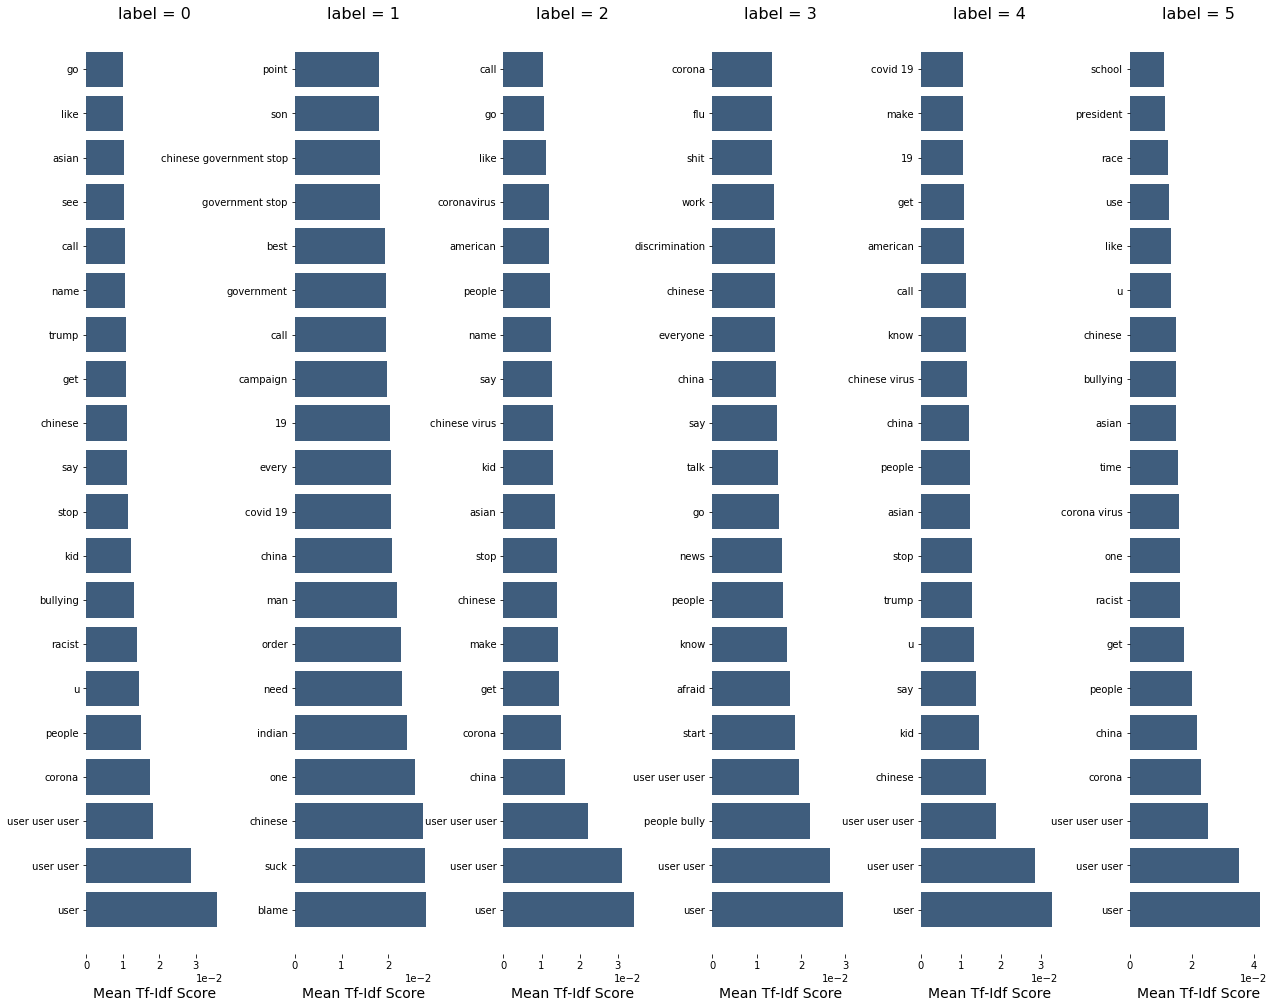

In [95]:
plot_tfidf_classfeats_h( tfidf_by_class )

In [40]:
df1 = tfidf_by_class[0]
df2 = tfidf_by_class[1]
df2[~df2.feature.isin(df1.feature.values)]

//anaconda3/envs/twitter_cyberbullying/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/envs/twitter_cyberbullying/lib/python3.7/site-packages/pandas/core/frame.py:2986: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


,feature,tfidf
72,nothing,0.004352
75,pandemic,0.004169
76,back,0.004121
79,fight,0.004094
80,cannot,0.004060
85,bully corona,0.003905
86,shit,0.003830
87,leave,0.003814
88,talk,0.003791
89,kill,0.003785


In [42]:
df1[~df1.feature.isin(df2.feature.values)]

,feature,tfidf
39,get bully,0.006435
70,user bully,0.004628
73,test,0.004566
75,virus bully,0.004516
78,maybe,0.004425
81,news,0.004240
82,man,0.004226
87,also,0.004126
89,mean,0.004087
90,call chinese,0.004054


In [27]:
# tweets classified as non bullying traces, seem to fall mostly into general covid related words. 
# the bullying trace category 

In [43]:
# Collect indices of false positive and negatives
fp_i = np.where((y_pred==1) & (y_test==0))[0]
fn_i = np.where((y_pred==0) & (y_test==1))[0]

all_ind = list(fp_i) + list(fn_i)

In [44]:
tfidf.shape

(4993, 13600)

//anaconda3/envs/twitter_cyberbullying/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


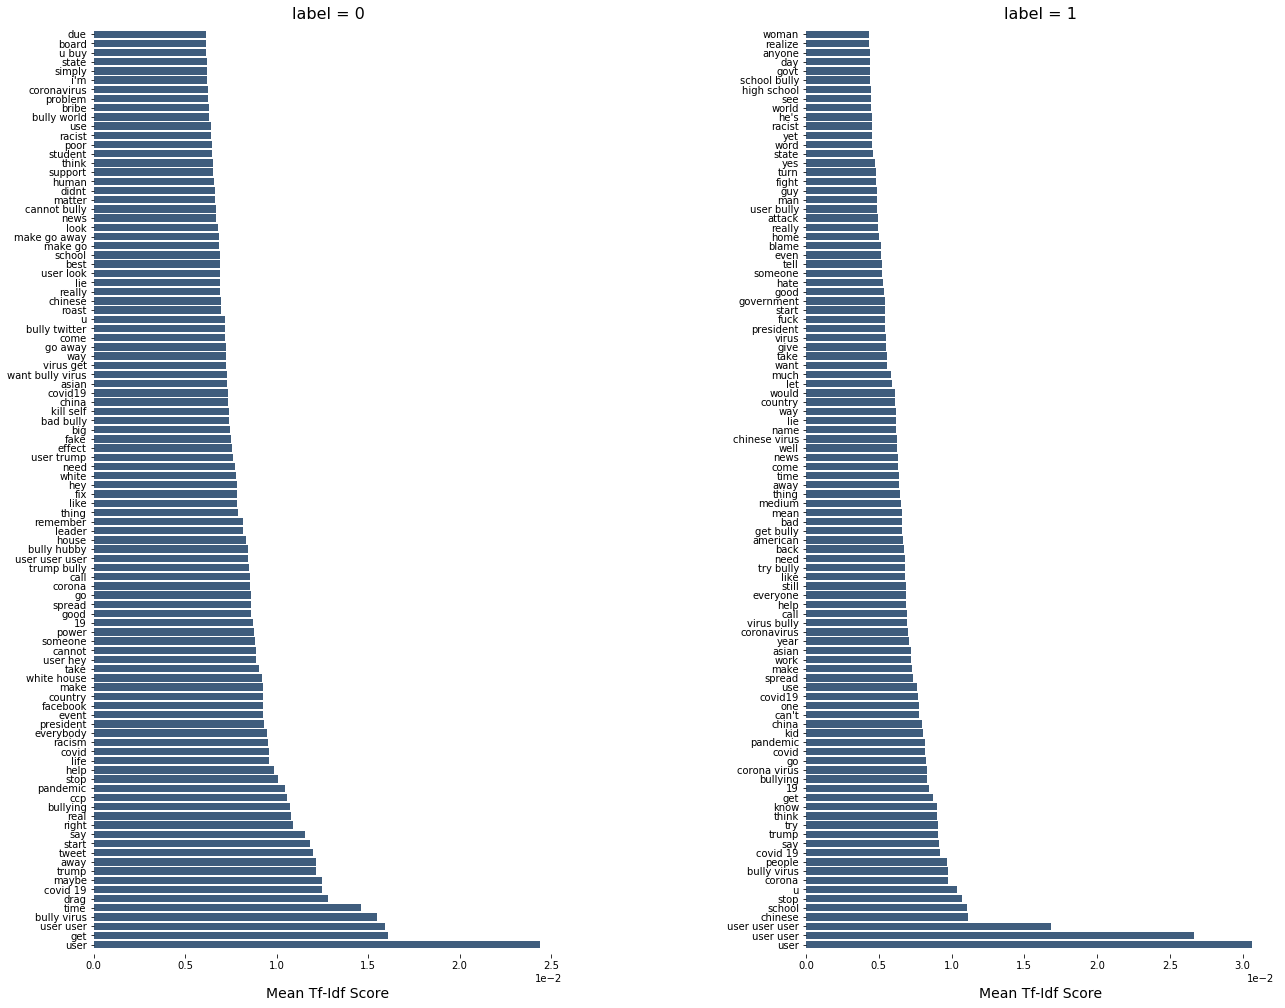

In [53]:
false_testdf = tfidf_df.iloc[len(X_train):]
err = top_feats_by_class(false_testdf.iloc[all_ind,:], y_test[all_ind], features, top_n=100)
plot_tfidf_classfeats_h( err )

In [59]:
err1 = tfidf_by_class[0]
err2 = tfidf_by_class[1]
err2[~err2.feature.isin(err1.feature.values)]

,feature,tfidf
72,nothing,0.004352
75,pandemic,0.004169
76,back,0.004121
79,fight,0.004094
80,cannot,0.004060
85,bully corona,0.003905
86,shit,0.003830
87,leave,0.003814
88,talk,0.003791
89,kill,0.003785


In [60]:
err1[~err1.feature.isin(err2.feature.values)]

,feature,tfidf
39,get bully,0.006435
70,user bully,0.004628
73,test,0.004566
75,virus bully,0.004516
78,maybe,0.004425
81,news,0.004240
82,man,0.004226
87,also,0.004126
89,mean,0.004087
90,call chinese,0.004054
